In [1]:
#| default_exp app

In [2]:
from fastbook import *

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [5]:
df.describe()

,fname,labels,is_valid
count,5011,5011,5011
unique,5011,473,2
top,000005.jpg,person,True
freq,1,408,2510


In [6]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [7]:
df.iloc[0,:]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [8]:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [9]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [10]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})

In [11]:
tmp_df

,a,b
0,1,3
1,2,4


In [12]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


In [13]:
dblock = DataBlock()

In [14]:
dsets = dblock.datasets(df)

In [15]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [16]:
dsets.items

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
...,...,...,...
5006,009954.jpg,horse person,True
5007,009955.jpg,boat,True
5008,009958.jpg,person bicycle,True
5009,009959.jpg,car,False


In [17]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [18]:
x['fname']

'008663.jpg'

In [19]:
dblock = DataBlock(get_x= lambda r: r['fname'], get_y= lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [20]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets[0]

('000005.jpg', 'chair')


We can see that the independent variable will need to be converted into a complete path, so that we can open it as an image, and the dependent variable will need to be split on the space character (which is the default for Python’s split function) so that it becomes a list:

In [21]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets[2]

(Path('/home/petewin/.fastai/data/pascal_2007/train/000009.jpg'),
 ['horse', 'person'])

In [22]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [23]:
dsets.train[0][1]

TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [24]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

In [25]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [26]:
df.index[df['is_valid']].to_list()

[0,
 1,
 2,
 4,
 6,
 7,
 8,
 10,
 12,
 18,
 19,
 22,
 25,
 26,
 27,
 28,
 30,
 32,
 34,
 38,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 52,
 53,
 54,
 55,
 56,
 58,
 59,
 61,
 62,
 63,
 69,
 70,
 71,
 73,
 76,
 77,
 83,
 84,
 85,
 89,
 90,
 91,
 94,
 100,
 102,
 104,
 105,
 106,
 107,
 108,
 111,
 113,
 116,
 117,
 118,
 120,
 121,
 123,
 124,
 125,
 126,
 128,
 130,
 134,
 135,
 136,
 137,
 138,
 142,
 144,
 147,
 148,
 149,
 150,
 151,
 154,
 158,
 160,
 161,
 162,
 164,
 165,
 167,
 169,
 171,
 172,
 173,
 177,
 178,
 181,
 185,
 186,
 188,
 189,
 195,
 197,
 201,
 204,
 205,
 206,
 207,
 208,
 209,
 212,
 213,
 215,
 216,
 218,
 221,
 222,
 223,
 224,
 226,
 233,
 234,
 235,
 237,
 239,
 240,
 241,
 243,
 244,
 245,
 246,
 249,
 250,
 251,
 252,
 256,
 258,
 263,
 264,
 267,
 269,
 271,
 278,
 279,
 282,
 283,
 284,
 286,
 289,
 292,
 293,
 294,
 296,
 298,
 300,
 301,
 305,
 306,
 310,
 311,
 312,
 314,
 316,
 318,
 319,
 320,
 321,
 324,
 325,
 326,
 328,
 329,
 331,
 334,
 335,
 3

In [27]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

In [28]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                    splitter=splitter,
                    get_x=get_x,
                    get_y=get_y)
                    
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [29]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

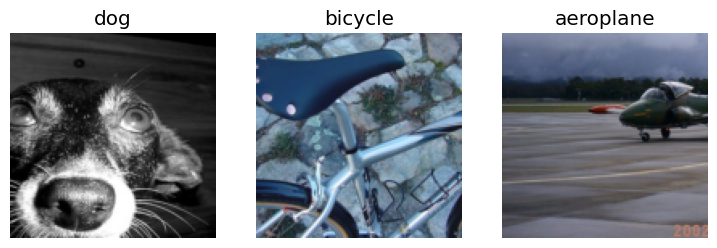

In [30]:
dls.show_batch(nrows=1, ncols=3)

In [31]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      /home/petewin/.fastai/data/pascal_2007/tra

### Binary Cross-Entropy

In [32]:
learn = vision_learner(dls, resnet18)

/home/petewin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/petewin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [34]:
activs[0]

TensorBase([-0.6604,  3.7083, -1.5740, -0.6980,  0.5220, -0.9594, -1.8903, -0.1805, -0.1008,  1.8911,  1.3607,  1.3528,  0.8708,  4.3651,  0.6839,  1.0118,  0.4205,  2.2555, -1.4704, -0.6334],
           grad_fn=<AliasBackward0>)

In [35]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [36]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0531, grad_fn=<AliasBackward0>)

In [37]:
learn = vision_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.152877,0.128021,0.936494,00:07
1,0.137660,0.121440,0.939940,00:06
2,0.119602,0.118781,0.939462,00:06


In [38]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.11878100037574768,0.90958172082901]

In [39]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.11878100037574768,0.9353587627410889]

In [40]:
preds,targs = learn.get_preds()

In [41]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9488)

In [42]:
df['labels'].value_counts()

person                                                408
car                                                   376
bird                                                  293
cat                                                   242
dog                                                   234
                                                     ... 
boat pottedplant chair diningtable person sofa dog      1
bottle diningtable person chair                         1
car bird                                                1
car person dog bus                                      1
sofa bottle person pottedplant                          1
Name: labels, Length: 473, dtype: int64

In [43]:
# df['label_test'] = df['labels'].str.split()
# all_labels = [item for sublist in df['label_test'].to_list() for item in sublist]
# len(set(all_labels))

In [44]:
xs = torch.linspace(0.05,0.95,29)
len(xs), xs

(29,
 tensor([0.0500, 0.0821, 0.1143, 0.1464, 0.1786, 0.2107, 0.2429, 0.2750, 0.3071, 0.3393, 0.3714, 0.4036, 0.4357, 0.4679, 0.5000, 0.5321, 0.5643, 0.5964, 0.6286, 0.6607, 0.6929, 0.7250, 0.7571, 0.7893,
         0.8214, 0.8536, 0.8857, 0.9179, 0.9500]))

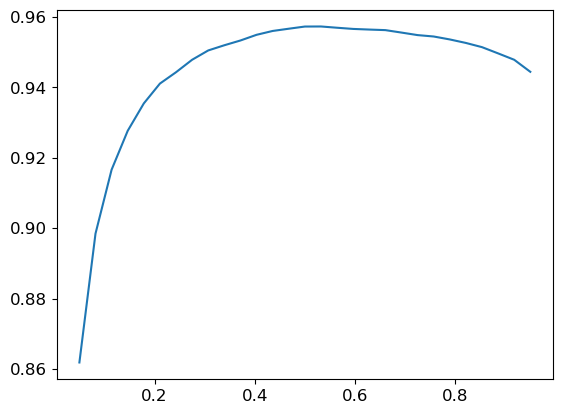

In [45]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

In [46]:
#| export
path = untar_data(URLs.BIWI_HEAD_POSE)

In [47]:
#| export
Path.BASE_PATH = path

In [48]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [49]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [50]:
#| export
img_files = get_image_files(path)

In [51]:
#| export
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')

In [52]:
img2pose(img_files[0])

Path('20/frame_00439_pose.txt')

In [53]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

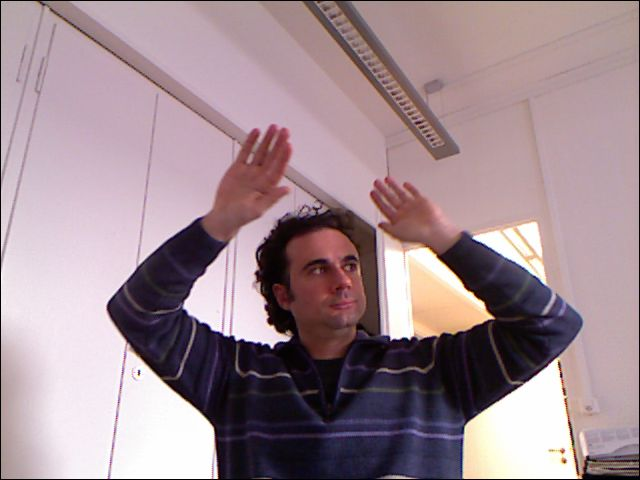

In [54]:
im

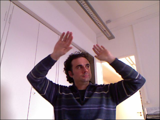

In [55]:
im.to_thumb(160)

In [56]:
#| export
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

In [57]:
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [58]:
cal[0,0]

517.679

In [59]:
#| export
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [60]:
get_ctr(img_files[0])

tensor([352.7322, 274.9907])

In [61]:
#| export
biwi = DataBlock((ImageBlock, PointBlock),
                  get_items=get_image_files,
                  get_y=get_ctr,
                  splitter=FuncSplitter(lambda o: o.parent.name=='13'),
                  batch_tfms=aug_transforms(size=(240,320)),
                  )

In [62]:
#| export
dls = biwi.dataloaders(path)

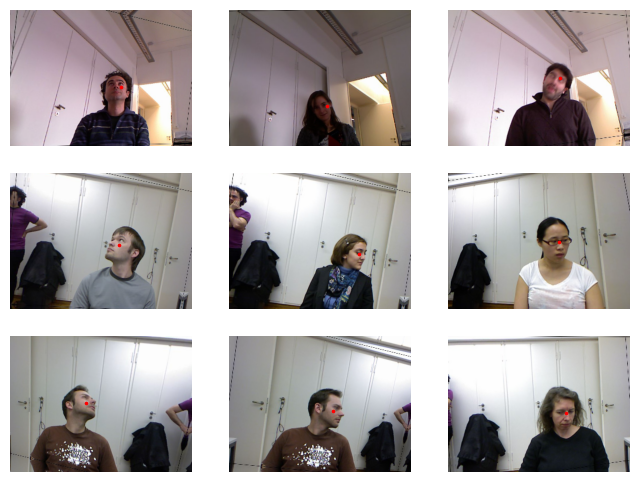

In [63]:
dls.show_batch(max_n=9, figsize=(8,6))

In [64]:
#| export
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [65]:
yb

TensorPoint([[[-0.4797,  0.0054]],

             [[ 0.1438, -0.2516]],

             [[-0.2740, -0.2241]],

             [[-0.0423,  0.4059]],

             [[-0.0880,  0.0499]],

             [[ 0.1819,  0.0163]],

             [[-0.0613,  0.0290]],

             [[-0.1239,  0.2103]],

             [[ 0.2465,  0.2679]],

             [[-0.3021,  0.2306]],

             [[-0.1598,  0.0349]],

             [[-0.1361,  0.3186]],

             [[-0.0016,  0.5348]],

             [[-0.3715,  0.0611]],

             [[ 0.1889,  0.1006]],

             [[-0.0605,  0.2269]],

             [[ 0.0647,  0.3093]],

             [[-0.2095, -0.0638]],

             [[-0.0485,  0.0012]],

             [[ 0.0695,  0.1855]],

             [[-0.0987, -0.2657]],

             [[-0.0176,  0.2173]],

             [[ 0.3162, -0.0167]],

             [[-0.0113, -0.0054]],

             [[-0.0408,  0.2515]],

             [[-0.3034,  0.1585]],

             [[-0.2640, -0.1002]],

             [[ 0.0664,  0.1

In [66]:
len(img_files)

15678

In [67]:
#| export
learn = vision_learner(dls, resnet18, y_range=(-1,1))

/home/petewin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/petewin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [68]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

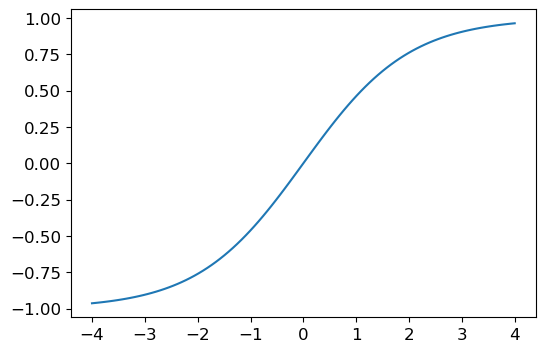

In [69]:
plot_function(partial(sigmoid_range, lo=-1, hi=1), min=-4, max=4)

In [70]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0014454397605732083)

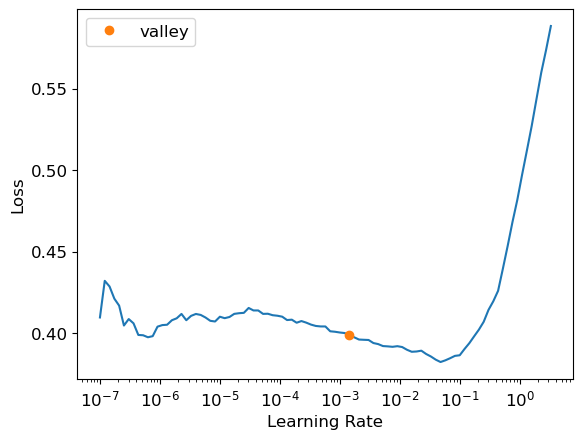

In [71]:
learn.lr_find()

In [72]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.007992,0.000859,01:14
1,0.002985,0.000399,01:13
2,0.001405,0.000081,01:13


In [73]:
math.sqrt(0.00001)

0.0031622776601683794

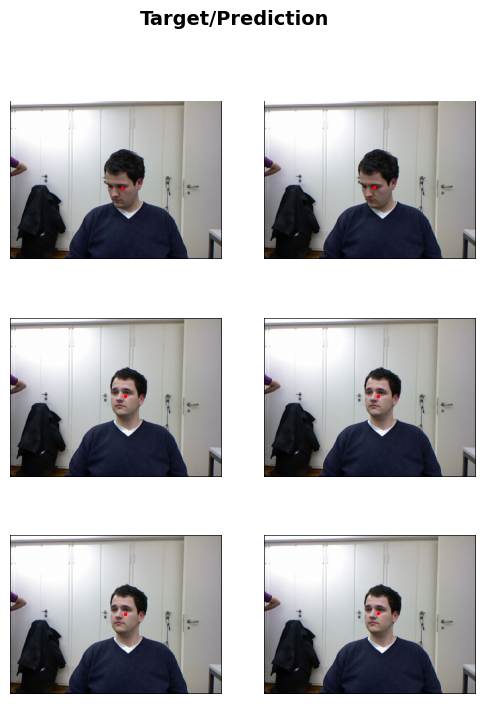

In [74]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

In [75]:
import nbdev
nbdev.export.nb_export('06_multicat.ipynb', 'app')
print('Export successful')

Export successful
